In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [4]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv('marketing_campaign.csv', sep='\t', encoding='latin-1')

# Show basic info about the file
print('Shape:', df.shape)
print('Column names:', df.columns.tolist())
display(df.head())
print(df.isnull().sum())


Shape: (2240, 29)
Column names: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [5]:
# Step 2: Remove rows with missing Income values
print('Before cleaning:', df.shape)
df = df.dropna(subset=['Income'])
print('After dropping missing Incomes:', df.shape)

# Confirm no missing values in Income
print('Missing values in Income:', df['Income'].isnull().sum())


Before cleaning: (2240, 29)
After dropping missing Incomes: (2216, 29)
Missing values in Income: 0


In [6]:
# Step 3: Feature Engineering - Create Age

# Calculate age as 2024 - Year_Birth
# (You can adjust '2024' if needed)
df['Age'] = 2025 - df['Year_Birth']

# Show distribution of ages
print('Age range:', df['Age'].min(), 'to', df['Age'].max())
print(df['Age'].describe())
display(df[['Year_Birth', 'Age']].head())


Age range: 29 to 132
count    2216.000000
mean       56.179603
std        11.985554
min        29.000000
25%        48.000000
50%        55.000000
75%        66.000000
max       132.000000
Name: Age, dtype: float64


,Year_Birth,Age
0,1957,68
1,1954,71
2,1965,60
3,1984,41
4,1981,44


In [7]:
# Step 4: Remove outlier ages (keep ages 18 to 100 only)
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]

# Check range after filtering
print('Filtered age range:', df['Age'].min(), 'to', df['Age'].max())
print('Remaining rows:', df.shape[0])


Filtered age range: 29 to 85
Remaining rows: 2213


In [8]:
# Step 5: Feature Engineering - Total Spending & Total Purchases
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spending_columns].sum(axis=1)

# Count all purchase channels
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchase_columns].sum(axis=1)

print(df[['Total_Spending', 'Total_Purchases']].describe())
display(df[['Total_Spending', 'Total_Purchases']].head())


       Total_Spending  Total_Purchases
count     2213.000000      2213.000000
mean       607.021690        12.564392
std        602.488663         7.204770
min          5.000000         0.000000
25%         69.000000         6.000000
50%        397.000000        12.000000
75%       1048.000000        18.000000
max       2525.000000        32.000000


,Total_Spending,Total_Purchases
0,1617,22
1,27,4
2,776,20
3,53,6
4,422,14


In [9]:
# Step 6: Feature Engineering - Family Size
# Family size = 1 (customer) + Kidhome + Teenhome
# (This assumes the customer themselves is in the household)
df['Family_Size'] = 1 + df['Kidhome'] + df['Teenhome']

print('Family size value counts:')
print(df['Family_Size'].value_counts())
display(df[['Kidhome', 'Teenhome', 'Family_Size']].head())


Family size value counts:
Family_Size
2    1115
1     632
3     416
4      50
Name: count, dtype: int64


,Kidhome,Teenhome,Family_Size
0,0,0,1
1,1,1,3
2,0,0,1
3,1,0,2
4,1,0,2


In [11]:
# Step 7: Feature Engineering - Robust Date Conversion, Tenure, and Recency
import pandas as pd

# Parse Dt_Customer using dayfirst=True (handles formats like '21-08-2013')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Calculate customer tenure in days since joining (using max enroll date as reference)
df['Customer_Tenure'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days

# Calculate Recency_Score (higher is better; max - Recency)
df['Recency_Score'] = df['Recency'].max() - df['Recency']

# Display results for Quick Review
display(df[['Dt_Customer', 'Customer_Tenure', 'Recency', 'Recency_Score']].head())
print('Customer tenure (days) range:', df['Customer_Tenure'].min(), 'to', df['Customer_Tenure'].max())
print('Recency_Score range:', df['Recency_Score'].min(), 'to', df['Recency_Score'].max())


,Dt_Customer,Customer_Tenure,Recency,Recency_Score
0,2012-09-04,663,58,41
1,2014-03-08,113,38,61
2,2013-08-21,312,26,73
3,2014-02-10,139,26,73
4,2014-01-19,161,94,5


Customer tenure (days) range: 0 to 699
Recency_Score range: 0 to 99


In [12]:
# Step 8: Feature Engineering - Average Transaction Value
# Avoid division by zero by adding 1 to Total_Purchases
# (adjust as needed if customers can actually purchase zero times)
df['Avg_Transaction_Value'] = df['Total_Spending'] / (df['Total_Purchases'] + 1)

print('Avg_Transaction_Value stats:')
print(df['Avg_Transaction_Value'].describe())
display(df[['Total_Spending', 'Total_Purchases', 'Avg_Transaction_Value']].head())


Avg_Transaction_Value stats:
count    2213.000000
mean       34.737294
std        28.477799
min         2.000000
25%        11.000000
50%        27.666667
75%        47.200000
max       173.230769
Name: Avg_Transaction_Value, dtype: float64


,Total_Spending,Total_Purchases,Avg_Transaction_Value
0,1617,22,70.304348
1,27,4,5.400000
2,776,20,36.952381
3,53,6,7.571429
4,422,14,28.133333


In [13]:
# Step 9: Feature Engineering - Encode Demographics

df['Is_Married'] = df['Marital_Status'].isin(['Married', 'Together']).astype(int)
df['Is_HighEd'] = df['Education'].isin(['Graduation', 'Master', 'PhD']).astype(int)

print('Is_Married counts:')
print(df['Is_Married'].value_counts())
print('Is_HighEd counts:')
print(df['Is_HighEd'].value_counts())
display(df[['Marital_Status', 'Is_Married', 'Education', 'Is_HighEd']].head())


Is_Married counts:
Is_Married
1    1429
0     784
Name: count, dtype: int64
Is_HighEd counts:
Is_HighEd
1    1961
0     252
Name: count, dtype: int64


,Marital_Status,Is_Married,Education,Is_HighEd
0,Single,0,Graduation,1
1,Single,0,Graduation,1
2,Together,1,Graduation,1
3,Together,1,Graduation,1
4,Married,1,PhD,1


In [14]:
# Step 10: Assemble clustering features into X
desired_features = [
    'Age', 'Income', 'Total_Spending', 'Total_Purchases',
    'Avg_Transaction_Value', 'Family_Size',
    'Customer_Tenure', 'Recency_Score',
    'Is_Married', 'Is_HighEd'
]

X = df[desired_features].copy()

print('Final clustering feature set:')
print(X.head())
print(f'Shape: {X.shape}')
print('Any missing values?', X.isnull().values.any())


Final clustering feature set:
   Age   Income  Total_Spending  Total_Purchases  Avg_Transaction_Value  \
0   68  58138.0            1617               22              70.304348   
1   71  46344.0              27                4               5.400000   
2   60  71613.0             776               20              36.952381   
3   41  26646.0              53                6               7.571429   
4   44  58293.0             422               14              28.133333   

   Family_Size  Customer_Tenure  Recency_Score  Is_Married  Is_HighEd  
0            1              663             41           0          1  
1            3              113             61           0          1  
2            1              312             73           1          1  
3            2              139             73           1          1  
4            2              161              5           1          1  
Shape: (2213, 10)
Any missing values? False


In [15]:
from sklearn.preprocessing import StandardScaler

# Step 11: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Scaled mean (should be ≈0):', X_scaled.mean())
print('Scaled std (should be 1):', X_scaled.std())
print('First row scaled values:', X_scaled[0])


Scaled mean (should be ≈0): 2.151213885943367e-17
Scaled std (should be 1): 1.0
First row scaled values: [ 1.01878463  0.23443526  1.67672297  1.30992941  1.24922201 -1.26491397
  1.52796826 -0.31077302 -1.35007558  0.35847715]


Explained variance ratio: [0.35348679 0.12313704]


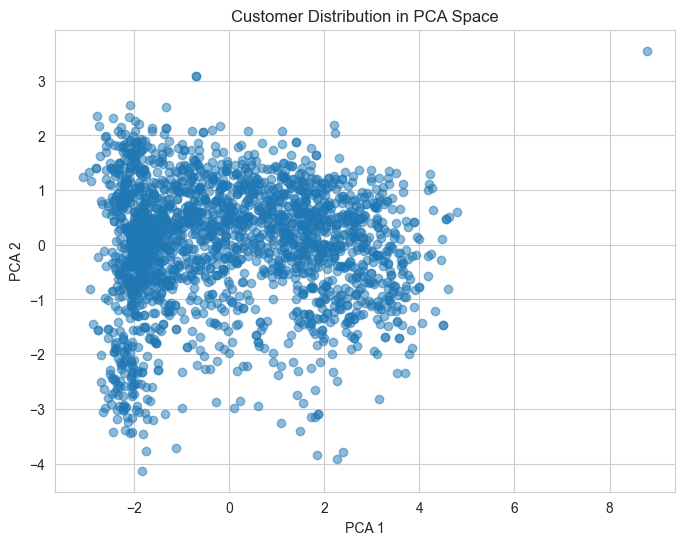

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 12: Dimensionality Reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Show explained variance
print('Explained variance ratio:', pca.explained_variance_ratio_)

# Scatter plot of customers in 2D PCA space
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Distribution in PCA Space')
plt.show()


K=2: Inertia=16029, Silhouette=0.2567
K=3: Inertia=14278, Silhouette=0.2529
K=4: Inertia=13129, Silhouette=0.1948
K=5: Inertia=12207, Silhouette=0.1636
K=6: Inertia=11543, Silhouette=0.1706
K=7: Inertia=10998, Silhouette=0.1787
K=8: Inertia=10512, Silhouette=0.1479
K=9: Inertia=10141, Silhouette=0.1569
K=10: Inertia=9608, Silhouette=0.1578


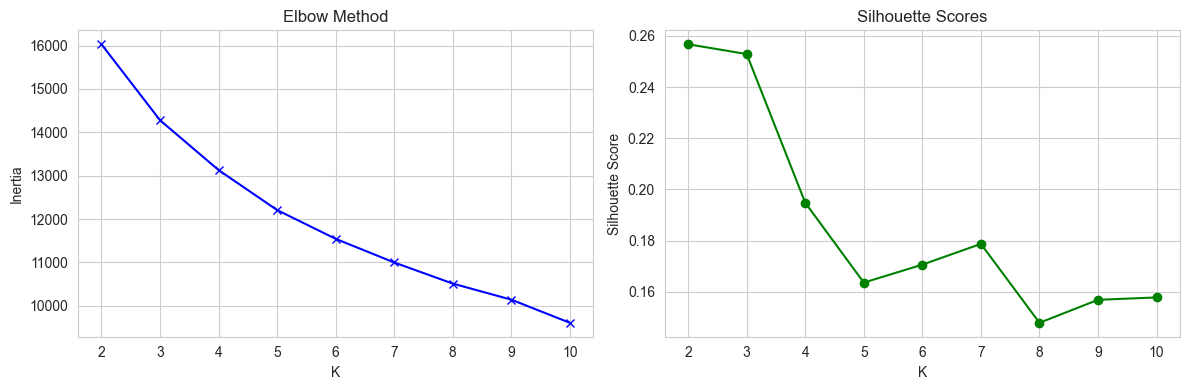

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(sil)
    print(f"K={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={sil:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, 'go-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()


In [18]:
# Step 13: Fit and apply KMeans with 3 clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Save cluster centers for reference (inverse scaling for interpretability)
cluster_centers = kmeans.cluster_centers_
cluster_centers_unscaled = scaler.inverse_transform(cluster_centers)
print('Cluster centers (unscaled for original features):\n', cluster_centers_unscaled)

# Show customer counts per cluster
print('Cluster sizes:')
print(df['KMeans_Cluster'].value_counts().sort_index())

# Quick mean-profile of each cluster
print(df.groupby('KMeans_Cluster')[desired_features].mean())


Cluster centers (unscaled for original features):
 [[5.84305718e+01 7.24195263e+04 1.25291715e+03 1.96977830e+01
  6.26806168e+01 1.50291715e+00 3.76568261e+02 4.91435239e+01
  6.13768961e-01 9.67327888e-01]
 [5.54973498e+01 3.99301926e+04 1.82454947e+02 7.89134276e+00
  1.65238914e+01 2.28710247e+00 3.31696996e+02 5.06475265e+01
  6.59893993e-01 1.00000000e+00]
 [5.00580357e+01 3.72100134e+04 2.81473214e+02 8.88839286e+00
  1.98718624e+01 1.93303571e+00 3.77714286e+02 4.99285714e+01
  6.96428571e-01 2.22044605e-16]]
Cluster sizes:
KMeans_Cluster
0     857
1    1132
2     224
Name: count, dtype: int64
                      Age        Income  Total_Spending  Total_Purchases  \
KMeans_Cluster                                                             
0               58.430572  72419.526254     1252.917153        19.697783   
1               55.497350  39930.192580      182.454947         7.891343   
2               50.058036  37210.013393      281.473214         8.888393   

          

Here's how to interpret your K-Means clusters (based on centers and means):

Cluster 0: Loyal High-Income Big Spenders
Age: 58

Income: $72,419

Total Spending: $1,253

Purchases: ~20

Avg Transaction: $63

Family Size: 1.5

Tenure: 377 days (longtime customers)

Recency: 49

High Education: 97%

Married/Partnered: 61%

These customers are older, wealthy, spend the most per year, buy the most often, and are present in the database for a long time. They are core, valuable and probably loyal buyers. They value both education and stable relationships.

Cluster 1: Older Multi-Person Value Buyers
Age: 55

Income: $39,930

Total Spending: $182

Purchases: ~8

Avg Transaction: $16.50

Family Size: 2.3 (more likely families)

Tenure: 332 days

Recency: 50

High Education: 100%

Married/Partnered: 66%

These are mid-income, older customers who spend less and make smaller purchases, and are likely to have larger households. They are also well-educated and likely value promotions and bulk offers.

Cluster 2: Younger Average Spenders
Age: 50

Income: $37,210

Total Spending: $281

Purchases: ~9

Avg Transaction: $19.87

Family Size: 1.93

Tenure: 377 days

Recency: 50

High Education: 0% (very low)

Married/Partnered: 70%

Compared to others, they are somewhat younger, lower income, spend moderately, and have less educational attainment, but many are married/partnered. These may be newer, more value-conscious, or underserved segments.

Cluster sizes:

Cluster 0: 857 customers

Cluster 1: 1,132 customers

Cluster 2: 224 customers

This shows you have a large population of moderate buyers (Cluster 1), a significant elite value segment (Cluster 0), and a distinct group of younger, moderately attached customers (Cluster 2).

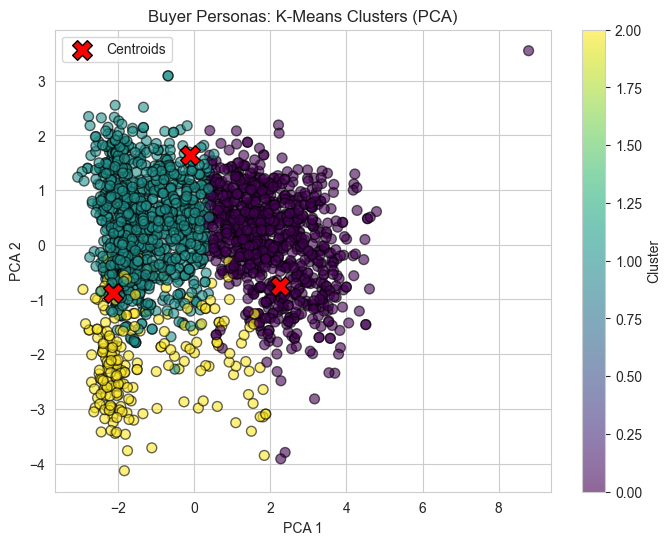

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Step 14: Visualize KMeans Clusters in PCA Space
labels = df['KMeans_Cluster']
centers_2d = PCA(n_components=2).fit_transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolor='k', s=50)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=200, label='Centroids', edgecolor='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Buyer Personas: K-Means Clusters (PCA)')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()


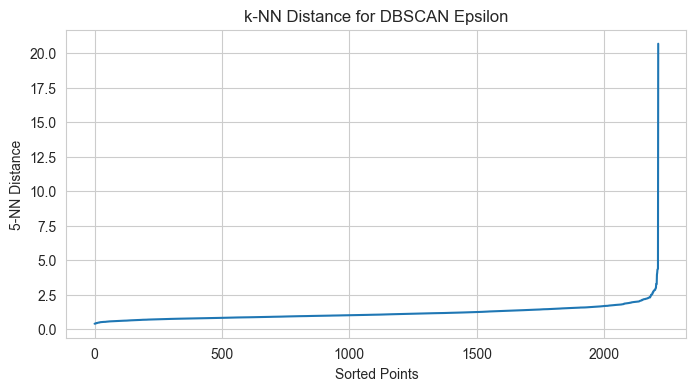

95th percentile suggested eps: 1.9009
DBSCAN_Cluster
 1    1245
 0     692
 2     165
-1      58
 3      53
Name: count, dtype: int64


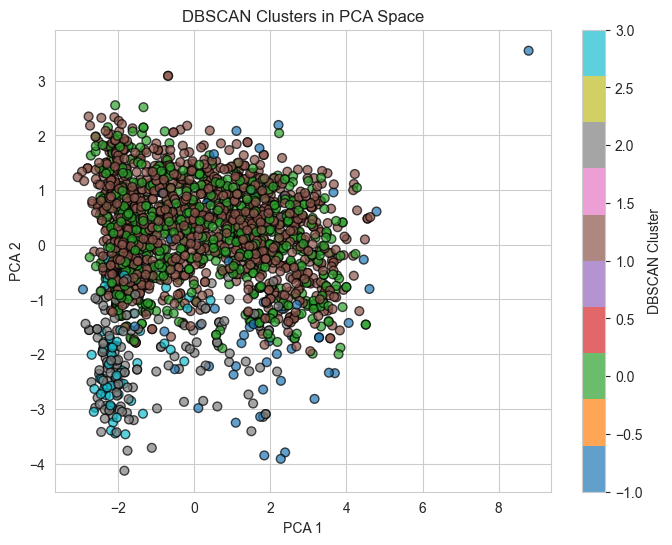

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Step 15: Estimate best eps using k-nearest neighbor distances (k=5)
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
dists, _ = neigh.kneighbors(X_scaled)
# Get largest "knee" via sorted distances
sorted_dists = np.sort(dists[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(sorted_dists)
plt.xlabel('Sorted Points')
plt.ylabel('5-NN Distance')
plt.title('k-NN Distance for DBSCAN Epsilon')
plt.show()

# Suggest an eps (try first at ~95th percentile)
eps_guess = np.percentile(sorted_dists, 95)
print(f'95th percentile suggested eps: {eps_guess:.4f}')

# Step 16: Run DBSCAN clustering with recommended eps
dbscan = DBSCAN(eps=eps_guess, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Show cluster distribution
print(df['DBSCAN_Cluster'].value_counts())

# Visualize in PCA space
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df['DBSCAN_Cluster'], cmap='tab10', s=40, alpha=0.7, edgecolor='k')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DBSCAN Clusters in PCA Space')
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.show()


In [21]:
# Profile each DBSCAN cluster (ignore noise if desired)
features_to_summarize = ['Age', 'Income', 'Total_Spending', 'Total_Purchases',
                        'Avg_Transaction_Value', 'Family_Size',
                        'Customer_Tenure', 'Recency_Score',
                        'Is_Married', 'Is_HighEd']

# Print size and mean profile for each cluster
for cl in sorted(df['DBSCAN_Cluster'].unique()):
    grp = df[df['DBSCAN_Cluster'] == cl]
    print(f"\n--- Cluster {cl if cl != -1 else 'Noise'}: {len(grp)} customers ---")
    print(grp[features_to_summarize].mean())



--- Cluster Noise: 58 customers ---
Age                         56.241379
Income                   85910.948276
Total_Spending            1111.517241
Total_Purchases             16.965517
Avg_Transaction_Value       63.487579
Family_Size                  1.741379
Customer_Tenure            429.344828
Recency_Score               51.034483
Is_Married                   0.327586
Is_HighEd                    0.413793
dtype: float64

--- Cluster 0: 692 customers ---
Age                         56.677746
Income                   52815.908960
Total_Spending             636.674855
Total_Purchases             12.809249
Avg_Transaction_Value       36.216297
Family_Size                  1.904624
Customer_Tenure            354.511561
Recency_Score               49.699422
Is_Married                   0.000000
Is_HighEd                    1.000000
dtype: float64

--- Cluster 1: 1245 customers ---
Age                         56.738153
Income                   52910.483534
Total_Spending             6

In [22]:
# Export selected fields with cluster assignments
cols_to_export = ['ID', 'KMeans_Cluster', 'DBSCAN_Cluster']
df[cols_to_export].to_csv('customer_segments.csv', index=False)
print('Customer segments exported to customer_segments.csv!')


Customer segments exported to customer_segments.csv!


In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Mask for non-noise points
mask = df['DBSCAN_Cluster'] != -1

if df['DBSCAN_Cluster'][mask].nunique() > 1:
    sil_score = silhouette_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
    db_index = davies_bouldin_score(X_scaled[mask], df.loc[mask, 'DBSCAN_Cluster'])
    print(f'Silhouette Score (DBSCAN, excl. noise): {sil_score:.4f}')
    print(f'Davies-Bouldin Index (DBSCAN, excl. noise): {db_index:.4f}')
else:
    print("DBSCAN: Not enough clusters for silhouette/Davies-Bouldin calculation.")


Silhouette Score (DBSCAN, excl. noise): 0.1423
Davies-Bouldin Index (DBSCAN, excl. noise): 2.2224


This buyer persona clustering project analyzed customer data from a marketing campaign, using feature engineering and two clustering approaches (K-Means and DBSCAN) to reveal actionable customer segments. After cleaning and preparing key features—such as age, income, total spend, purchase habits, tenure, and demographics—K-Means identified three major groups: loyal high-income big spenders, value-oriented families, and younger moderate spenders. DBSCAN confirmed these segments while highlighting additional edge-case customers and outliers.

The personas differed in spending patterns, household size, and engagement, suggesting targeted marketing strategies: VIP loyalty programs for top spenders, bundle deals for families, and onboarding offers for moderate buyers. Cluster quality metrics showed moderate separation, typical for real-world customer data.

Finally, cluster assignments were exported for practical use in CRM and marketing, enabling campaign targeting for each group. This project demonstrates how data science can translate raw customer records into clear, actionable marketing strategies.